# NN (L) Global Sustainable Equity time series forecasting using Prophet

## Start timing the analysis

In [ ]:
import timeit
start_time = timeit.default_timer()

## Import all the necessary libraries

In [ ]:
## Import all the necessary libraries
import time
import os
import datetime as dt
import pandas as pd
import io
import matplotlib.pyplot as plt
from fbprophet import Prophet
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
from dask.distributed import Client # import Dask for parallelising cross validation

## Import, clean and visualise the historical data

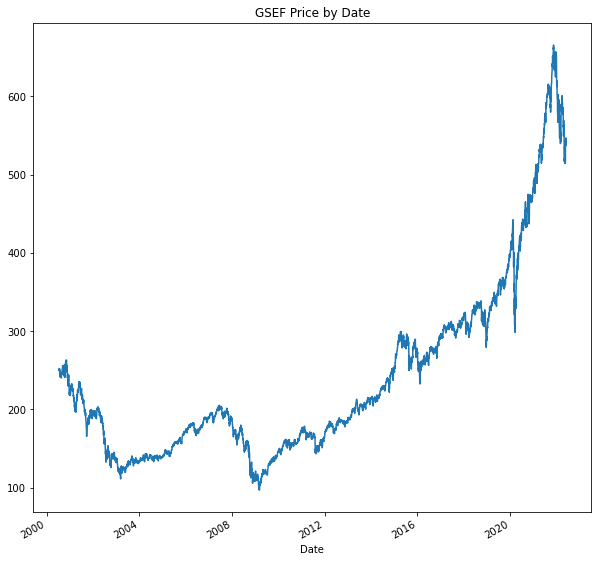

In [1]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_column',None)
tomorrow = (dt.date.today() + dt.timedelta(days=1)).isoformat() #get tomorrow in iso format as needed'''
url = pd.read_html("https://markets.ft.com/data/funds/tearsheet/historical?s=LU0119216553:EUR", header=0)
table = url[0]
gsef_latest = table[['Date', 'Close']]
gsef_latest_selected= gsef_latest.copy()

gsef_latest_selected['Date'] = gsef_latest_selected.loc[:,'Date'].str[-12:]
gsef_latest_selected['Date'] = pd.to_datetime(gsef_latest_selected['Date'], dayfirst=True)

gsef_historical= pd.read_csv('gsef_output/historical_gsef.csv', parse_dates=['Date'], dayfirst=True)

gsef = pd.concat([gsef_latest_selected, gsef_historical], ignore_index=True).sort_values(by="Date")

gsef = gsef.reset_index(drop=True)

gsef['pct_change']= (gsef["Close"].pct_change()*100).round(2)

gsef = gsef.drop_duplicates('Date')

gsef.to_csv('gsef_output/historical_gsef.csv', index=False)

gsef.plot(x= 'Date', y='Close', figsize=(10,10), title= 'GSEF Price by Date', legend=False)

historical_chart= 'gsef_output/gsef_historical.png'

# Check if the historical data's chart exists and save its latest version
if os.path.exists(historical_chart):
  os.remove(historical_chart)
else:
  print("The historical chart didn't exist and it has been created.")

plt.savefig('gsef_output/gsef_historical.png')

plt.show()

In [3]:
# Brief Description of our dataset
gsef.describe()

Close   pct_change
count  5533.000000  5532.000000
mean    238.640848     0.019863
std     117.122922     1.082118
min      96.810000    -9.930000
25%     157.420000    -0.470000
50%     195.420000     0.070000
75%     291.380000     0.550000
max     665.450000     9.540000

In [4]:
gsef.info() # Check whether the date is as object type or date type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5533 entries, 0 to 5550
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5533 non-null   datetime64[ns]
 1   Close       5533 non-null   float64       
 2   pct_change  5532 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 172.9 KB


In [5]:
gsef.head()

Date   Close  pct_change
0 2000-07-07  250.00         NaN
1 2000-07-10  250.00        0.00
2 2000-07-11  250.00        0.00
3 2000-07-12  249.61       -0.16
4 2000-07-13  249.80        0.08

In [7]:
# Drop the columns
gsef = gsef.drop('pct_change', axis=1)
gsef.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

gsef.head()

ds       y
0 2000-07-07  250.00
1 2000-07-10  250.00
2 2000-07-11  250.00
3 2000-07-12  249.61
4 2000-07-13  249.80

## Hyperparameter tuning

In [9]:
client = Client()  # connect to the cluster

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'daily_seasonality': [False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(gsef)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='30 days', parallel="dask")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Making 41 forecasts with cutoffs between 2002-08-17 00:00:00 and 2022-05-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49861' processes=4 threads=8, memory=15.39 GiB>
2022-06-05 11:39:38,337 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:49281', name: 3, status: running, memory: 10, processing: 2>
2022-06-05 11:39:57,435 - distributed.nanny - WARNING - Worker process still alive after 3.9999969482421878 seconds, killing
INFO:prophet:Making 41 forecasts with cutoffs between 2002-08-17 00:00:00 and 2022-05-04 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49861' processes=4 threads=8, memory=15.39 GiB>
2022-06-05 11:48:20,826 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:49901', name: 0, status: running, memory: 8, processing: 1>
2022-06-05 11:48:39,932 - distributed.na

    changepoint_prior_scale  seasonality_prior_scale  daily_seasonality  \
0                     0.001                     0.01              False   
1                     0.001                     0.10              False   
2                     0.001                     1.00              False   
3                     0.001                    10.00              False   
4                     0.010                     0.01              False   
5                     0.010                     0.10              False   
6                     0.010                     1.00              False   
7                     0.010                    10.00              False   
8                     0.100                     0.01              False   
9                     0.100                     0.10              False   
10                    0.100                     1.00              False   
11                    0.100                    10.00              False   
12                    0.5

In [10]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'daily_seasonality': False}


In [11]:
changepoint_prior_scale= best_params['changepoint_prior_scale']
seasonality_prior_scale= best_params['seasonality_prior_scale']

## Initiating and training the Prophet algorithm

Steps for using Prophet:
- Make sure you replace closing price for y and date for ds.
- Fit that dataframe to Prophet in order to detect future patterns.
- Predict the upper and lower prices of the closing price.

In [12]:
m = Prophet(daily_seasonality=False, changepoint_prior_scale= changepoint_prior_scale, seasonality_prior_scale= seasonality_prior_scale)

m.fit(gsef)

In [13]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
5893 2023-05-30  675.744496  633.715249  718.166699
5894 2023-05-31  676.340488  633.466721  717.781765
5895 2023-06-01  676.691601  632.458545  717.326214
5896 2023-06-02  677.067478  634.003770  720.431289
5897 2023-06-03  677.528709  635.206430  717.726030

You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.

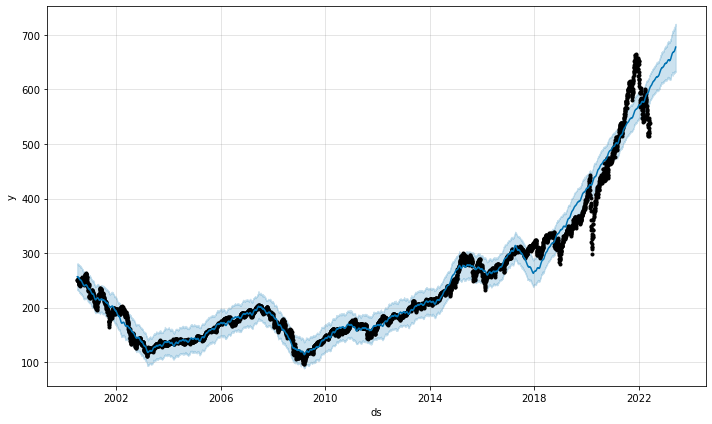

In [14]:
fig1 = m.plot(forecast)

If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

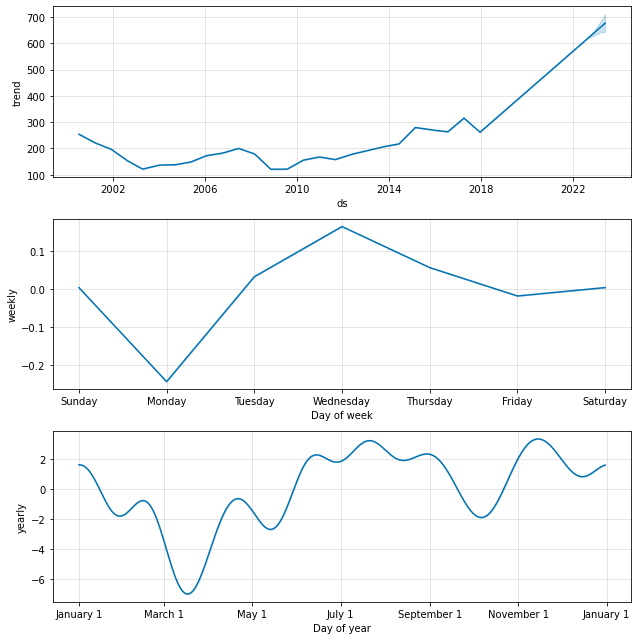

In [15]:
fig2 = m.plot_components(forecast)

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages.

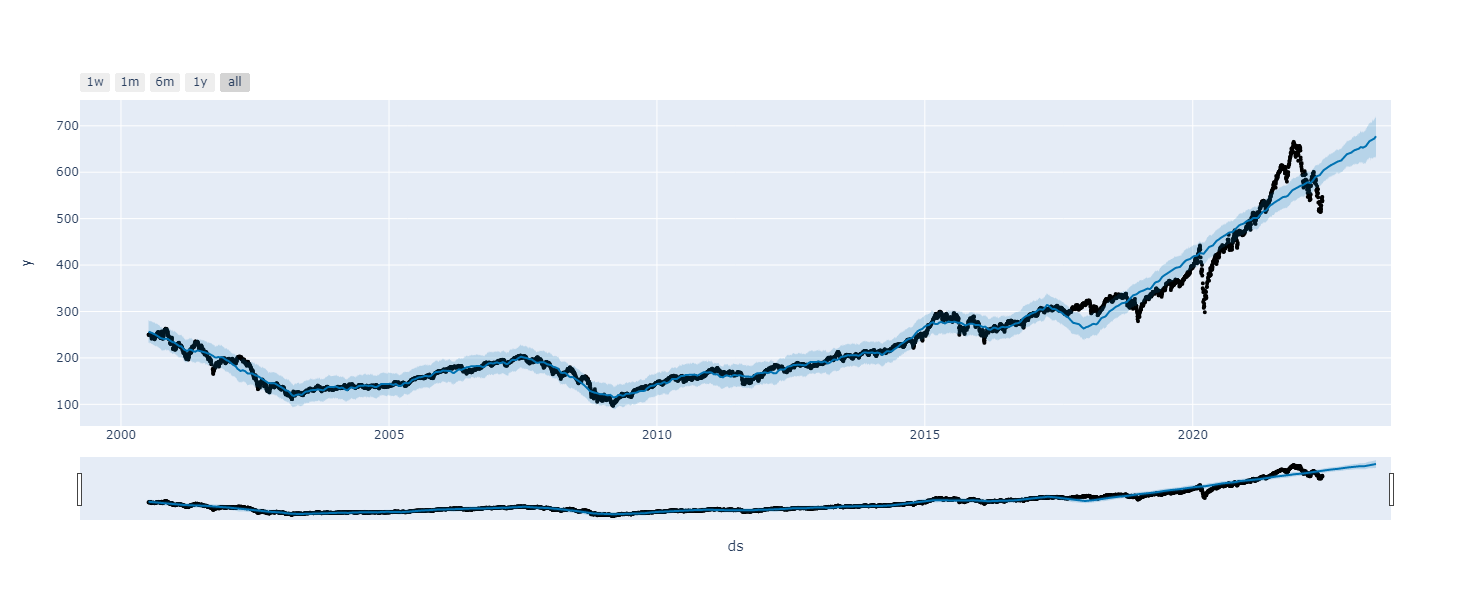

In [16]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

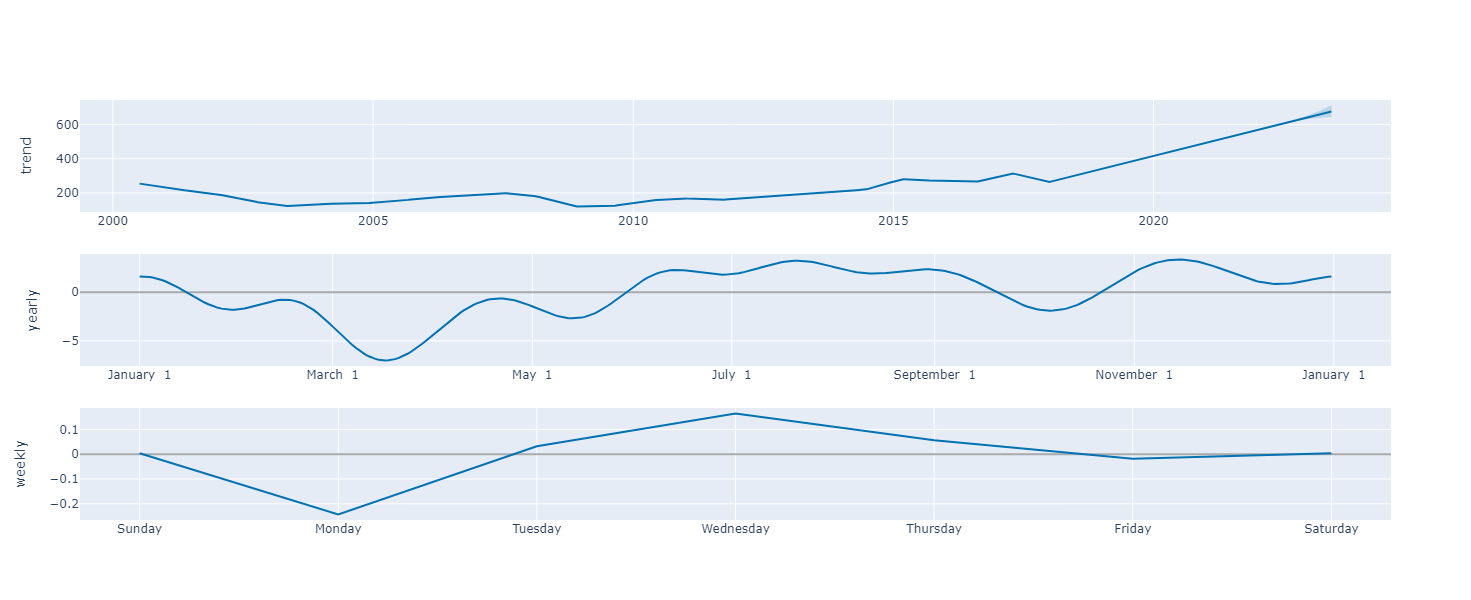

In [17]:
plot_components_plotly(m, forecast)

## Parallelized Cross validation

In [18]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel="dask")

INFO:prophet:Making 39 forecasts with cutoffs between 2002-09-11 00:00:00 and 2021-06-03 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:49861' processes=1 threads=2, memory=3.85 GiB>


In [19]:
df_cv.head()

ds        yhat  yhat_lower  yhat_upper       y     cutoff
0 2002-09-12  139.510731  135.149677  143.762026  142.28 2002-09-11
1 2002-09-13  138.096876  133.401371  142.189288  140.68 2002-09-11
2 2002-09-16  135.780736  131.151465  140.219405  142.15 2002-09-11
3 2002-09-17  134.860566  130.501195  139.434805  140.08 2002-09-11
4 2002-09-18  133.569801  128.825656  137.690903  136.16 2002-09-11

In [20]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon         mse       rmse        mae      mape     mdape     smape  \
0 37 days  551.047042  23.474391  15.671373  0.067418  0.044807  0.069295   
1 38 days  558.041027  23.622892  15.795711  0.067963  0.045433  0.069822   
2 39 days  574.681182  23.972509  15.973589  0.068410  0.045433  0.070283   
3 40 days  588.474638  24.258496  16.123527  0.068945  0.044807  0.070871   
4 41 days  603.043406  24.556942  16.292061  0.069621  0.045437  0.071571   

   coverage  
0  0.462832  
1  0.460398  
2  0.459704  
3  0.463534  
4  0.465497

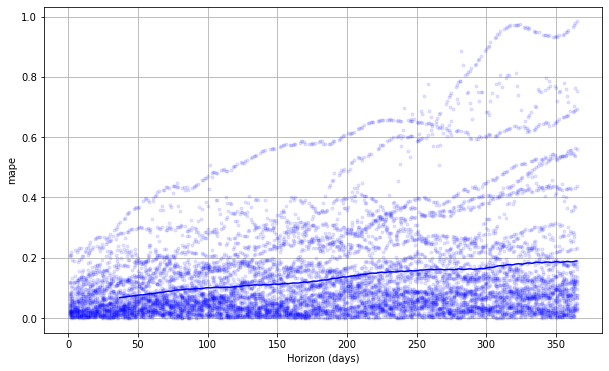

In [21]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Next:

1) Can more hyperparameter tuning can be done to significantly improve accuracy?
2) Check if Prophet's output has been suppressed 
3) If necessary, re-order the analysis in the notebook and automate the analysis wherever possible
4) Remove any unnecessary or low value steps from the analysis 
5) Document the notebook 
6) Create a .py script of the notebook 
7) Publish the project publicly on Github

## Calculate the analysis' and forecast's timing

In [22]:
# Calculate and print the time elapsed to run ETL process and the date and time of the latest run
time_elapsed = timeit.default_timer() - start_time

time_elapsed_seconds = int(time_elapsed % 60)

now = dt.datetime.now()

print("\n Success! Your GSEF forecast using Prophet has been updated in {} seconds on {}".format(time_elapsed_seconds, now.strftime("%Y-%m-%d %H:%M:%S")))


 Success! Your GSEF forecast using Prophet has been updated in 54 seconds on 2022-06-05 14:49:22
